In [1]:
import pandas as pd
import numpy as np
import glob
import requests
import json
import gc
import pickle
import concurrent.futures

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.under_sampling import TomekLinks

from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

RND_STATE = 100412

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Configuration

In [3]:
# weather links
# ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt

In [4]:
WEATHER_API_KEY = ''

In [5]:
STARTING_DATE = '2017-03-01'
END_DATE = '2018-03-01'

In [6]:
DATA_FOLDER = 'historical_data'
DICT_FOLDER = 'dictionaries'
WEATHER_FOLDER = 'weather_data'

In [7]:
DATA_FILE = 'merged_data.csv'

In [8]:
CLF_FILE = 'classifiers.data'

## Merging and loading data

### Loading flights data

In [9]:
def get_file_list(folder_name):
    return glob.glob(folder_name + '/*.csv')

In [10]:
def read_csv(file_name):
    file_data = pd.read_csv(file_name, dtype={'CANCELLATION_CODE': str}, parse_dates=True)
    file_data['FL_DATE'] = pd.to_datetime(file_data.FL_DATE)
    return file_data

In [11]:
def read_csv_backup(file_name):
    file_data = pd.read_csv(file_name, dtype={'cancellation_code': str}, parse_dates=True)
    file_data['fl_date'] = pd.to_datetime(file_data.fl_date)
    file_data = file_data.drop(['Unnamed: 0'], axis = 1)
    return file_data

In [12]:
def gather_data(folder_name):
    file_list = get_file_list(folder_name)
    
    files_data = read_csv(file_list[0])
    for file in log_progress(file_list[1:], every=1):
        tmp = read_csv(file)
        files_data = pd.concat([files_data, tmp])
        del tmp
        
    files_data = files_data.reindex()
    files_data.columns = map(str.lower, files_data.columns)
    return files_data

In [13]:
def append_city_names(files_data, dict_folder_name):
    files_data_df = files_data.copy()
    city_info = pd.read_csv(dict_folder_name + '/city_codes_info.csv')
    city_info['Description'] =  city_info['Description'].str.replace(',.*|\/.*| City', '')
    
    city_info.columns = ['origin_city_market_id', 'origin_city_name']
    files_data_df = pd.merge(files_data_df, city_info, on='origin_city_market_id')
    
    city_info.columns = ['dest_city_market_id', 'dest_city_name']
    files_data_df = pd.merge(files_data_df, city_info, on='dest_city_market_id')
    
    del city_info
    
    return files_data_df

In [14]:
def load_data(folder_name, dict_folder_name):
    files_data = gather_data(folder_name)
    files_data = files_data.sort_values(by='fl_date')
    files_data = files_data.dropna(thresh=9)
    files_data = append_city_names(files_data, dict_folder_name)
    return files_data.reindex()

In [15]:
data = load_data(DATA_FOLDER, DICT_FOLDER)

VBox(children=(HTML(value=''), IntProgress(value=0, max=11)))

In [16]:
data.to_csv(DATA_FILE)

### Loading weather data

In [17]:
def get_data_city_names(data_df):
    return list(set(list(data['origin_city_name'].values) + list(data['dest_city_name'].values)))

In [18]:
def load_city_codes(dict_folder_name):
    tmp = pd.read_csv(dict_folder_name + '/weather_city_codes_info.csv')
    tmp['name'] = tmp['name'].str.lower()
    tmp['name'] = tmp['name'].str.replace(',.*|\/.*| city', '')
    tmp['name'] = tmp['name'].str.strip()
    return tmp

In [19]:
def get_weather_city_codes(data_df, dict_folder_name):
    weather_cities_codes = load_city_codes(dict_folder_name)
    data_city_names = get_data_city_names(data_df)
    
    processed_cities = []
    failed_cities = []
    for city in data_city_names:
        city_data = weather_cities_codes[weather_cities_codes['name'].str.contains(city.lower())]
        if len(city_data) == 0:
            failed_cities.append(city)
        else:
            processed_cities.append({'name': city, 'weather_id': city_data['id'].values[0]})
    return processed_cities, failed_cities

In [20]:
def get_weather_for_city(city_info, start_date, end_date, api_key, limit=1000, offset=0):
    req_url = 'http://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid={0}&startdate={1}&enddate={2}&limit={3}&offset={4}'
    req_url = req_url.format(city_info['weather_id'], start_date, end_date, limit, offset)
    
    result_json = requests.get(req_url, headers={'token': api_key}, timeout=20)
    result_json = json.loads(result_json.content)
    result_data = pd.DataFrame(result_json['results'])
    
    if result_json['metadata']['resultset']['count'] > offset + limit:
        return pd.concat([result_data, get_weather_for_city(city_info, start_date, end_date, api_key, limit, offset + limit)])
    else:
        return result_data

In [21]:
def save_weather_data(data_df, dict_folder_name, save_folder, start_date, end_date, api_key):
    weather_city_codes, error_cities = get_weather_city_codes(data_df, dict_folder_name)
    
    for city in log_progress(weather_city_codes, every=1):
        try:
            city_weather = get_weather_for_city(city, start_date, end_date, api_key)
            city_weather.to_csv(save_folder + '/' + city['name'] + '.csv')
        except Exception as e:
            error_cities.append(city)
            print(e)
    return weather_city_codes, error_cities

In [ ]:
ok, err = save_weather_data(data, DICT_FOLDER, WEATHER_FOLDER, STARTING_DATE, END_DATE, WEATHER_API_KEY)

In [22]:
def filter_data_by_available_weather(data_df, weather_data_folder):
    city_list = get_file_list(weather_data_folder)
    fixed_city_list = []
    for city in city_list:
        fixed_city_list.append(city.replace(weather_data_folder + '/', '').replace('.csv', ''))
    
    tmp_df = data_df[(data_df['origin_city_name'].isin(fixed_city_list)) | (data_df['dest_city_name'].isin(fixed_city_list))]
    return tmp_df, city_list 

In [23]:
def read_weather_file(weather_data_folder, weather_file_path):
    weather_data = pd.read_csv(weather_file_path)
    weather_data['date'] = pd.to_datetime(weather_data.date)
    weather_data = weather_data.drop(['Unnamed: 0', 'attributes', 'station'], axis=1)
    weather_data = weather_data.rename(columns={'date': 'fl_date'})
    weather_data = weather_data.drop_duplicates(["fl_date", "datatype"])
    weather_data = weather_data.pivot_table(weather_data, index='fl_date', columns='datatype', aggfunc=sum, fill_value=0)
    weather_data = weather_data.reset_index()
    weather_data_value = weather_data['value'].copy()
    weather_data_value['fl_date'] = weather_data['fl_date']
    del weather_data
    selected_cols = ['fl_date', 'AWND', 'SNOW', 'SNWD', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WT10', 'WT11']
    available_cols = list(set(weather_data_value.columns).intersection(selected_cols))
    na_cols = list(set(selected_cols) - set(available_cols))
    weather_data_value = weather_data_value[available_cols]
    
    for na_col in na_cols:
        weather_data_value[na_col] = None
    
    weather_data_value = weather_data_value.rename({'SNOW': 'snowfall_mm', 'SNWD': 'snow_depth_mm', 'AWND': 'avg_wind_ms', 'WT08': 'smoke', 'WT01': 'fog', 'WT03': 'thunder'})
    weather_data_value['city_name'] = weather_file_path.replace(weather_data_folder + '/', '').replace('.csv', '')
    
    return weather_data_value

In [24]:
def merge_data_with_weather(data_df, weather_data_folder):
    filtered_df, city_list = filter_data_by_available_weather(data_df, weather_data_folder)
    dfs = []
    
    for city in log_progress(city_list, every=1):
        tmp = read_weather_file(weather_data_folder, city)
        tmp = tmp.rename(columns={'city_name': 'origin_city_name'})
        dfs.append(pd.merge(filtered_df, tmp, on=['fl_date', 'origin_city_name']))
        tmp = tmp.rename(columns={'origin_city_name': 'dest_city_name'})
        dfs.append(pd.merge(filtered_df, tmp, on=['fl_date', 'dest_city_name']))
        del tmp
        gc.collect()
        
    final_df = pd.concat(dfs)
    final_df = final_df.sort_values(by=['fl_date', 'origin_city_name', 'dest_city_name'])
    return final_df

In [25]:
data = merge_data_with_weather(data, WEATHER_FOLDER)

VBox(children=(HTML(value=''), IntProgress(value=0, max=235)))

In [26]:
data.to_csv(DATA_FILE)

## Preprocessing data 

In [33]:
data = read_csv_backup(DATA_FILE)

In [34]:
def get_dependent_variable_value(cancelled, cancelled_code, dep_delay_new):
    if cancelled == 1 or cancelled_code != 'E':
        return 'cancelled_flight'
    if dep_delay_new > 300:
        return 'extra_long_delay'
    if dep_delay_new > 120:
        return 'long_delay'
    if dep_delay_new > 30:
        return 'moderate_delay'
    return 'no_delay'

In [35]:
def preprocess_data(file_data):
    data_df = file_data.copy()
    data_df = data_df.drop(['origin_airport_id', 'origin_airport_seq_id', 'origin_city_market_id', 'dest_airport_id', 'dest_airport_seq_id', 'dest_city_market_id', 'year', 'unnamed: 28'], axis=1)
    data_df = data_df.fillna(value={'cancellation_code': 'E'})
    data_df = data_df.fillna(0)
    data_df['fog'] = list(map(int , (data_df['WT01'] + data_df['WT02']).values > 0))
    data_df['hail'] = list(map(int , (data_df['WT04'] + data_df['WT05']).values > 0))
    data_df['damaging_wind'] = list(map(int , (data_df['WT10'] + data_df['WT11']).values > 0))
    data_df = data_df.drop(['WT01', 'WT02', 'WT04', 'WT05', 'WT06', 'WT10', 'WT11'], axis=1)
    data_df = data_df.rename(columns={'SNOW': 'snowfall', 'SNWD': 'snow_depth', 'AWND': 'average_wind_speed','WT03': 'thunder', 'WT07': 'dust', 'WT08': 'haze', 'WT09': 'snow'})
    
    data_df['cancellation_code'] = list(map(str, data_df['cancellation_code']))
    data_df['carrier'] = list(map(str, data_df['carrier']))
    data_df['dest'] = list(map(str, data_df['dest']))
    data_df['dest_city_name'] = list(map(str, data_df['dest_city_name']))
    data_df['origin'] = list(map(str, data_df['origin']))
    data_df['origin_city_name'] = list(map(str, data_df['origin_city_name']))
    data_df['cancelled'] = list(map(int, data_df['cancelled']))
    data_df['diverted'] = list(map(int, data_df['diverted']))
    
    with concurrent.futures.ProcessPoolExecutor(16) as pool:
        data_df['status'] = list(pool.map(get_dependent_variable_value, data_df['cancelled'], data_df['cancellation_code'], data_df['dep_delay_new'], chunksize=1_000))
    return data_df

In [36]:
data = preprocess_data(data)

## Analysis with additional data

Overall data info

In [38]:
data.describe()

,average_wind_speed,snowfall,snow_depth,thunder,dust,haze,snow,cancelled,carrier_delay,crs_dep_time,...,fl_num,late_aircraft_delay,month,nas_delay,quarter,security_delay,weather_delay,fog,hail,damaging_wind
count,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,...,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06,4.666579e+06
mean,2.797055e+01,5.401027e-01,2.967996e+00,1.996743e-01,2.674550e-03,1.417231e-01,7.290137e-04,1.352640e-02,3.687214e+00,1.332838e+03,...,2.222141e+03,4.380498e+00,7.430768e+00,2.367079e+00,2.778629e+00,1.760090e-02,4.958002e-01,3.588335e-01,5.467817e-03,4.311938e-03
std,2.551131e+01,8.485501e+00,2.975954e+01,3.997556e-01,5.164685e-02,3.487659e-01,2.699041e-02,1.155138e-01,2.873237e+01,4.901060e+02,...,1.727191e+03,2.211855e+01,2.861298e+00,1.517216e+01,9.802593e-01,1.434897e+00,1.065670e+01,4.796583e-01,7.374226e-02,6.552363e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.200000e+02,...,8.460000e+02,0.000000e+00,5.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.325000e+03,...,1.765000e+03,0.000000e+00,7.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.735000e+03,...,3.083000e+03,0.000000e+00,1.000000e+01,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.073000e+03,8.230000e+02,1.626000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.810000e+03,2.359000e+03,...,7.439000e+03,1.756000e+03,1.200000e+01,1.605000e+03,4.000000e+00,8.270000e+02,1.587000e+03,1.000000e+00,1.000000e+00,1.000000e+00


Correlations

In [39]:
data.corr()

,average_wind_speed,snowfall,snow_depth,thunder,dust,haze,snow,cancelled,carrier_delay,crs_dep_time,...,fl_num,late_aircraft_delay,month,nas_delay,quarter,security_delay,weather_delay,fog,hail,damaging_wind
average_wind_speed,1.000000,0.020475,0.003610,0.016132,0.024853,0.015841,0.027020,0.045726,0.004003,-0.003864,...,-0.003611,0.006299,-0.099981,0.005490,-0.095455,-0.001895,0.003766,0.013802,0.035896,0.010429
snowfall,0.020475,1.000000,0.398069,-0.029398,-0.003262,0.005742,0.117315,0.037992,0.005786,-0.000082,...,0.013806,0.006976,0.014339,0.008094,0.001422,0.000196,0.011704,0.031742,0.029591,-0.002844
snow_depth,0.003610,0.398069,1.000000,-0.048602,-0.005116,-0.008279,0.059578,0.007379,0.002162,0.004208,...,-0.003125,0.000601,-0.005430,0.001638,-0.025987,0.001629,0.005594,-0.000810,0.016864,-0.003448
thunder,0.016132,-0.029398,-0.048602,1.000000,0.034769,0.116344,-0.013412,0.015514,0.019167,-0.001374,...,-0.022956,0.050081,-0.125450,0.057899,-0.099691,0.000153,0.025595,0.351190,0.067620,0.049227
dust,0.024853,-0.003262,-0.005116,0.034769,1.000000,0.120741,-0.000476,0.001264,0.000590,0.001411,...,-0.000131,0.007047,-0.003034,0.007999,0.002658,-0.000366,0.006133,-0.021051,-0.002883,0.004001
haze,0.015841,0.005742,-0.008279,0.116344,0.120741,1.000000,0.012176,0.006990,0.005336,-0.002471,...,-0.001689,0.011300,0.004419,0.017414,0.006345,0.000224,0.008736,0.231572,0.002873,0.000387
snow,0.027020,0.117315,0.059578,-0.013412,-0.000476,0.012176,1.000000,0.015532,0.003221,-0.000096,...,0.013880,0.004567,-0.004094,0.006759,-0.011792,0.000892,0.008752,0.031189,0.004027,0.001858
cancelled,0.045726,0.037992,0.007379,0.015514,0.001264,0.006990,0.015532,1.000000,-0.015027,0.012305,...,-0.001015,-0.023191,-0.001103,-0.018269,-0.009463,-0.001436,-0.005448,0.031566,0.000550,0.013245
carrier_delay,0.004003,0.005786,0.002162,0.019167,0.000590,0.005336,0.003221,-0.015027,1.000000,0.014480,...,0.019843,0.051375,-0.013335,0.020539,-0.011813,-0.000749,-0.002219,0.012001,0.001725,0.000672
crs_dep_time,-0.003864,-0.000082,0.004208,-0.001374,0.001411,-0.002471,-0.000096,0.012305,0.014480,1.000000,...,0.025200,0.108690,-0.002847,0.028504,-0.003176,0.002960,0.014277,-0.001334,0.001102,0.002236


In [40]:
def check_correlations(data_df, min_v=0.7):
    corr = data_df.corr()
    corrs = []
    for i in corr:
        for j in corr.index[corr[i] >= min_v]:
            if i != j and j not in corrs and i not in corrs:
                corrs.append(j)
                print("%s-->%s: r^2=%f" % (i,j, corr[i][corr.index == j].values[0]))
    if len(corrs) == 0:
        print('Everything is perfect')

In [41]:
check_correlations(data)

carrier_delay-->dep_delay_new: r^2=0.713772
month-->quarter: r^2=0.959306


Plotting data

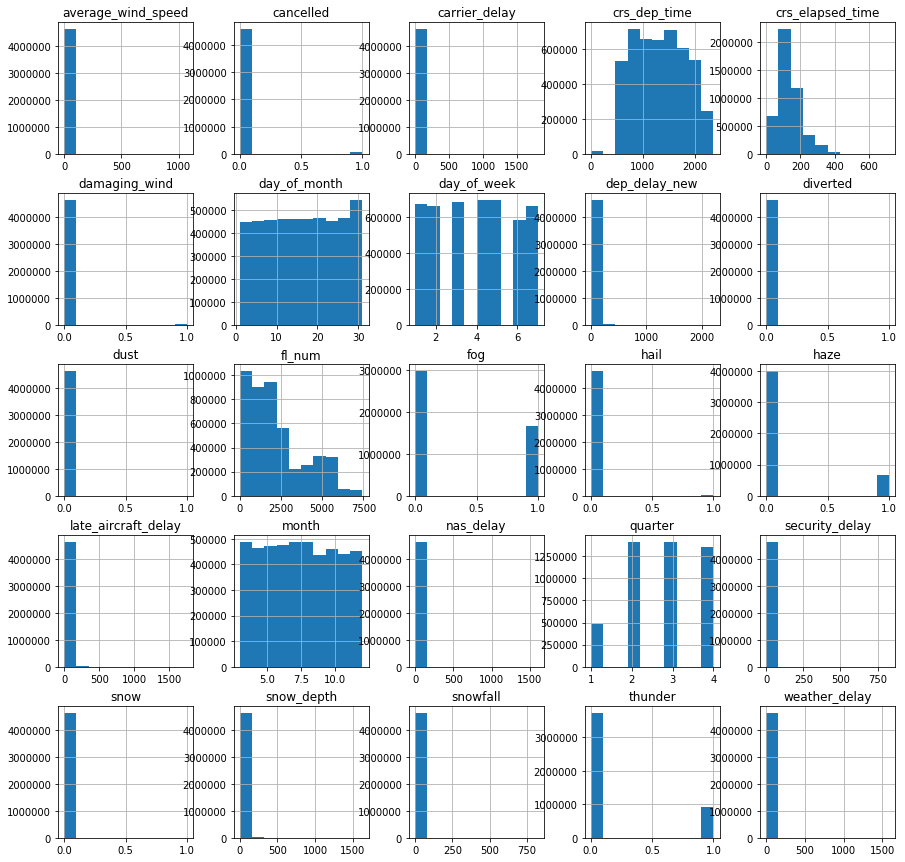

In [42]:
data.hist(figsize=(15, 15));

Plotting classes

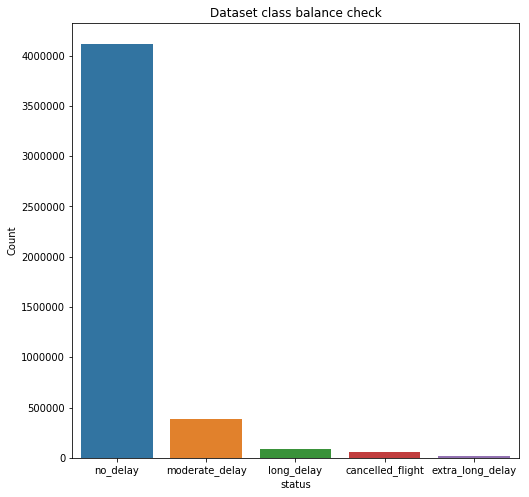

In [43]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(x = data.status)
ax.set_title('Dataset class balance check')
ax.set_ylabel('Count')
plt.show()

huge imbalance here

Day / delay

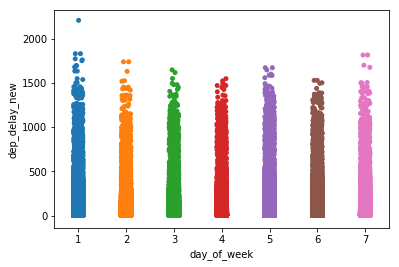

In [44]:
sns.stripplot(x="day_of_week", y="dep_delay_new", data=data, jitter=True)

Month / Delay

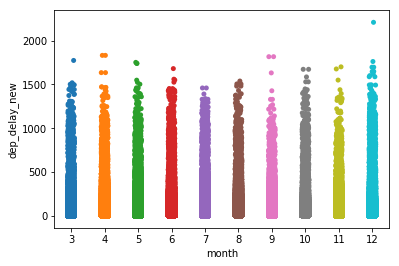

In [45]:
sns.stripplot(x="month", y="dep_delay_new", data=data, jitter=True)

/Users/bulhakovdmytro/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'Delays in time')

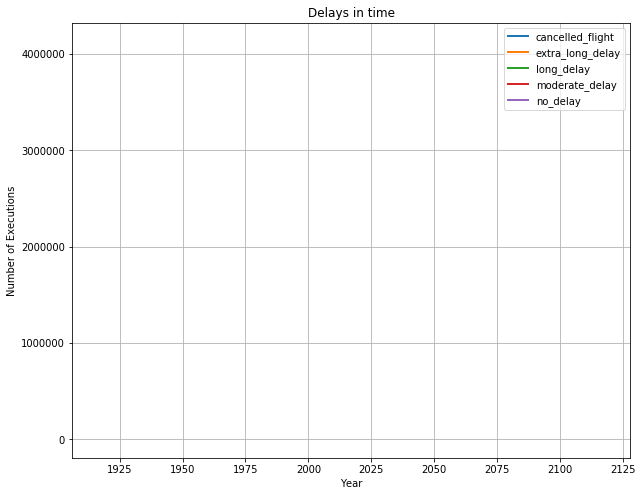

In [46]:
plot_df = data.copy()
plot_df['fl_date'] = pd.to_datetime(plot_df['fl_date'], dayfirst=True, infer_datetime_format = True)
plot_df.set_index('fl_date', inplace=True)
# set Race as categorical
plot_df['status'] = plot_df['status'].astype('category')

grouped = plot_df.groupby('status')

plt.clf()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, axisbg='w', frame_on=True)

for key, group in grouped:
    plot_df = group.groupby(lambda x: x.year).count()
    plot_df['status'].plot(label=key, ax=ax, lw=2.)

# label x and y axis
plt.xlabel("Year")
plt.ylabel("Number of Executions")
# turn off background grid
ax.grid(b=None)
# show a semi-transparent legend
leg = ax.legend(loc='best')
leg.get_frame().set_alpha(0.75)
# set a title
plt.title('Delays in time')

Flights per airline

In [47]:
airlines_group = data[['status', 'carrier']]
airlines_group_num = airlines_group.groupby(['carrier']).size()
airlines_group = data[['status', 'carrier']]
airlines_group = airlines_group[(airlines_group['status'] != 'no_delay') & (airlines_group['status'] != 'short_delay')]
airlines_group_delays_num = airlines_group.groupby(['carrier']).size()
delay_info = pd.DataFrame({'Carrier': np.unique(airlines_group.carrier.values), 'Number of flights': airlines_group_num.values, 'Number of delays': airlines_group_delays_num.values})

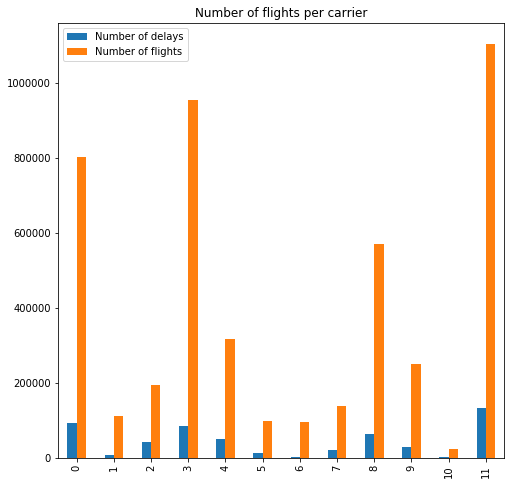

In [48]:
delay_info.plot(kind='bar', figsize=(8, 8), title = 'Number of flights per carrier')

Delay ratings

In [49]:
delay_info['Delay index'] = delay_info['Number of delays'] / delay_info['Number of flights']

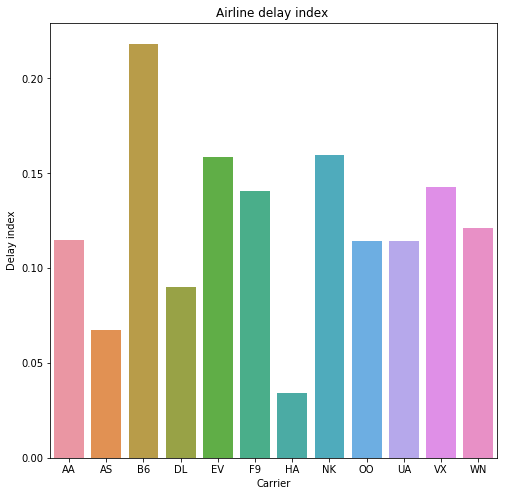

In [50]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(x="Carrier", y="Delay index", data=delay_info)
ax.set_title('Airline delay index ')
plt.show()

## Additional preprocessing

In [122]:
data2 = data[data['origin'] == 'ALB']

In [123]:
working_df = data2

In [124]:
def additional_preprocessing(data_df):
    data_info = data_df.copy()
    data_info = data_info.drop(['cancellation_code', 'cancelled', 'carrier_delay', 'dep_delay_new', 'late_aircraft_delay', 'nas_delay', 'security_delay', 'weather_delay', 'diverted', 'origin_city_name', 'dest_city_name'], axis = 1)
    
    data_info = data_info.drop(['snowfall', 'snow_depth', 'thunder', 'dust', 'haze', 'snow', 'fog', 'hail', 'damaging_wind'], axis = 1)
    
    data_info = data_info.drop(['tail_num'], axis = 1)
    
    data_info['crs_dep_time'] = list(map(int, working_df['crs_dep_time'].values / 100))
    
    return data_info

In [125]:
working_df = additional_preprocessing(working_df)

## Processing

In [126]:
def add_airline_delay_index(carrier):
    return delay_info[delay_info['Carrier'] == carrier]['Delay index'].values[0]

In [127]:
def process_data(data_df):
    data_info = data_df.copy()
    
    airlines_group = data_info[['status', 'carrier']]
    airlines_group_num = airlines_group.groupby(['carrier']).size()
    airlines_group = data_info[['status', 'carrier']]
    airlines_group = airlines_group[(airlines_group['status'] != 'no_delay') & (airlines_group['status'] != 'short_delay')]
    airlines_group_delays_num = airlines_group.groupby(['carrier']).size()
    delay_info = pd.DataFrame({'Carrier': np.unique(airlines_group.carrier.values), 'Number of flights': airlines_group_num.values, 'Number of delays': airlines_group_delays_num.values})
    delay_info['Delay index'] = delay_info['Number of delays'] / delay_info['Number of flights']
    
    with concurrent.futures.ProcessPoolExecutor(16) as pool:
        data_info['airline_delay_index'] = list(pool.map(add_airline_delay_index, data_info['carrier'], chunksize=1_000))
    
    # data_info['airline_delay_index'] = data_df.apply (lambda row: add_airline_delay_index(row, delay_info), axis=1)
    
    data_info = pd.get_dummies(data_info, columns=['origin', 'dest', 'carrier'])
    data_info['day_of_year'] = (data_info['fl_date'] - data_info['fl_date'].min())  / np.timedelta64(1,'D')
    data_info = data_info.drop(['fl_date'], axis=1)
    
    return data_info

In [128]:
working_df = process_data(working_df)

## Train test split

In [129]:
X_train, X_test, y_train, y_test = train_test_split(working_df.loc[:, working_df.columns != 'status'], working_df['status'], test_size = 0.3, random_state = RND_STATE)

## Due to huge dataset performing undersampling

In [130]:
print('Before undersampling: ', len(X_train))

Before undersampling:  7443


In [131]:
tl = TomekLinks(random_state = RND_STATE)
X_train, y_train = tl.fit_sample(X_train, y_train)

In [132]:
print('After undersampling:', len(X_train))

After undersampling: 6792


## Predictions

In [133]:
classifiers = []

In [134]:
class ModelTester():
    def __init__(self, parameters, model, scoring='f1_micro', njobs=-1, cv=3):
        self.cv = GridSearchCV(model, param_grid=parameters, scoring = scoring, n_jobs = njobs, cv = cv, verbose = 1)
    
    def test_model(self, Xtrain, ytrain, Xtest, ytest):
        self.cv.fit(Xtrain, ytrain);
        print('Best score cv: ', self.cv.best_score_)
        print('Params: ', self.cv.best_params_)
    
        y_predicted = self.cv.predict(Xtest)
        print('Score on test sample:', f1_score(ytest, y_predicted, average='micro'))
        
    def best_estimator(self):
        return self.cv.best_estimator_

### Random Forest

In [135]:
param = {'criterion':['gini', 'entropy'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'],
         'max_depth':[2, 4, 8, 16, 32, 64], 'class_weight':['balanced', None], 'n_estimators': [10, 20, 30]}

mt = ModelTester(parameters = param, model = RandomForestClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
rf_clf = mt.best_estimator()
classifiers.append({'name': 'Random Forest Classifier', 'clf': rf_clf})

Fitting 3 folds for each of 504 candidates, totalling 1512 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1512 out of 1512 | elapsed:  2.2min finished


Best score cv:  0.9405182567726738
Params:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 32, 'max_features': 4, 'n_estimators': 30}
Score on test sample: 0.9037919147602632


### SVC

In [136]:
param = {'C': np.linspace(0.01, 0.03, num=3), 
              'class_weight':['balanced', None], 'kernel':['linear'],
              'decision_function_shape' : ['ovo', 'ovr', None]}

mt = ModelTester(parameters = param, model = SVC(random_state=RND_STATE, cache_size=2048))
# mt.test_model(X_train, y_train, X_test, y_test)
# svc_clf = mt.best_estimator()
# classifiers.append({'name': 'SVC', 'clf': svc_clf})

### AdaBoostClassifier

In [137]:
param = {'algorithm': ['SAMME.R', 'SAMME'], 'learning_rate': [0.1, 0.3, 0.6, 0.8, 1.0]}
mt = ModelTester(parameters = param, model = AdaBoostClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
adc_clf = mt.best_estimator()
classifiers.append({'name': 'AdaBoost Classifier', 'clf': adc_clf})

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.1s finished


Best score cv:  0.9293286219081273
Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1}
Score on test sample: 0.8903165151989971


### Decision Tree Classifier

In [138]:
param = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 
         'class_weight' : ['balanced'], 'random_state':[RND_STATE], 'presort':[True, False]}

mt = ModelTester(parameters = param, model = DecisionTreeClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
dtc_clf = mt.best_estimator()
classifiers.append({'name': 'Decision Tree Classifier', 'clf': dtc_clf})

Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s


Best score cv:  0.90650765606596
Params:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 4, 'presort': True, 'random_state': 100412, 'splitter': 'best'}
Score on test sample: 0.8696333437793794


[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:    5.2s finished


### K-Neighbors Classifier

In [139]:
param = {'n_neighbors': [30, 50, 65, 70], 'weights': ['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
         'leaf_size' : [10, 15, 20], 'p':[1, 2]}

mt = ModelTester(parameters = param, model = KNeighborsClassifier())
mt.test_model(X_train, y_train, X_test, y_test)
knn_clf = mt.best_estimator()
classifiers.append({'name': 'K-Neighbors Classifier', 'clf': knn_clf})

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  3.8min finished


Best score cv:  0.9335983510011778
Params:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
Score on test sample: 0.8931369476653087


### Gradient Boosting Classifier

In [140]:
param = {'loss': ['deviance'], 'max_features':[1, 2, 3, 4, 5, 'log2', 'auto'], 'presort':[True, False],
         'n_estimators':[200, 300], 'min_samples_leaf' : [3]}

mt = ModelTester(parameters = param, model = GradientBoostingClassifier(random_state=RND_STATE))
mt.test_model(X_train, y_train, X_test, y_test)
gbc_clf = mt.best_estimator()
classifiers.append({'name': 'Gradient Boosting Classifier', 'clf': gbc_clf})

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  3.1min finished


Best score cv:  0.9358068315665489
Params:  {'loss': 'deviance', 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 300, 'presort': True}
Score on test sample: 0.8981510498276403


## Working with the results

In [141]:
def save_clfs(file_name, data_to_save):
    with open(file_name, 'wb') as f:
        pickle.dump(data_to_save, f)

In [142]:
def load_clfs(file_name):
    with open('data.pickle', 'rb') as f:
        return pickle.load(f)

In [143]:
save_clfs(CLF_FILE, classifiers)

### Results per classifier:

In [144]:
def print_importances_internal(data_df, imp_list):
    print('Top 10 features:')
    val_zip = zip(data_df.columns, imp_list) 
    for a, b, in sorted(val_zip, key = lambda zp_gb: zp_gb[1], reverse = True)[:10]:
        print("{0}: {1}".format(a, b))

In [145]:
def print_importances(data_df, model):
    if hasattr(model, 'feature_importances_'):
        print_importances_internal(data_df, model.feature_importances_)
    elif hasattr(model, 'coef_'):
        print_importances_internal(data_df, model.coef_.flatten())

In [146]:
results_data = []
for clf in log_progress(classifiers, every = 1):
    print('\n' + clf['name'])
    score = f1_score(clf['clf'].predict(X_test), y_test, average='micro')
    print('F1 score: ', score)
    results_data.append({'Classifier': clf['name'], 'F1 Score': score})
    print_importances(data, clf['clf'])

VBox(children=(HTML(value=''), IntProgress(value=0, max=5)))


Random Forest Classifier
F1 score:  0.9037919147602632
Top 10 features:
damaging_wind: 0.14804529837673844
thunder: 0.13593240441553472
average_wind_speed: 0.13114237185380884
dust: 0.09877245166944154
snowfall: 0.08580335206976099
haze: 0.08127812686585413
snow_depth: 0.07885954359190597
snow: 0.06985770551818198
cancellation_code: 0.03652841728718728
cancelled: 0.02384951425419292

AdaBoost Classifier
F1 score:  0.8903165151989971
Top 10 features:
snowfall: 0.26
thunder: 0.2
damaging_wind: 0.2
snow_depth: 0.14
haze: 0.1
average_wind_speed: 0.04
cancelled: 0.04
hail: 0.02
dust: 0.0
snow: 0.0

Decision Tree Classifier
F1 score:  0.8696333437793794
Top 10 features:
thunder: 0.17130437232082005
damaging_wind: 0.12547037761399887
snow: 0.10110723299514988
average_wind_speed: 0.09517071242297889
snow_depth: 0.09352470761368281
snowfall: 0.09004162272925387
dust: 0.08960085752931753
haze: 0.05558259615250623
cancellation_code: 0.04330136102303842
hail: 0.017987312843687615

K-Neighbors Cla

Text(0.5,1,'Models and F1 score')

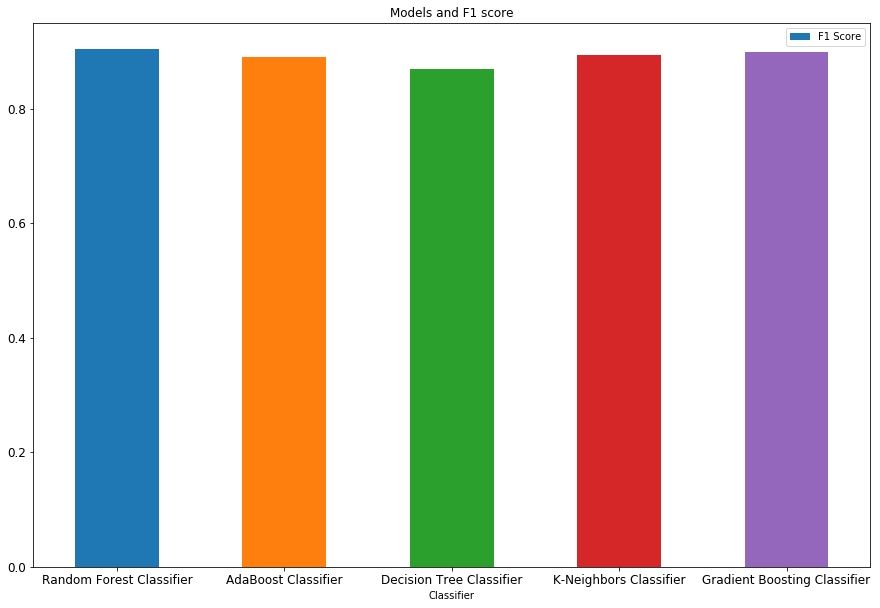

In [147]:
pd.DataFrame(results_data).plot(x='Classifier', y='F1 Score', kind = 'bar', figsize = (15, 10), fontsize = 12)
plt.xticks(rotation = 0)
plt.title('Models and F1 score', fontsize = 12)